In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import to_rgba
import sys
import os
import graph_tool.all as gt
# adding Folder_2/subfolder to the system path
sys.path.insert(0, '/work/ccnr/glover.co/net_design/NetDesign')
import network_design as nd
sys.path.insert(0, '/work/ccnr/glover.co/net_design/NetDesign')
import network_design_cont_time as nd_cont
import netrd
import copy
import json

In [2]:
distances = {
    # 'Jaccard':                 netrd.distance.JaccardDistance(),
    # 'Hamming':                 netrd.distance.Hamming(),
    # # 'HammingIpsenMikhailov':   netrd.distance.HammingIpsenMikhailov(),
    # 'Frobenius':               netrd.distance.Frobenius(),
    'PolynomialDissimilarity': netrd.distance.PolynomialDissimilarity()}
    # 'DegreeDivergence':        netrd.distance.DegreeDivergence(),
    # 'PortraitDivergence':      netrd.distance.PortraitDivergence(),
    # 'QuantumJSD':              netrd.distance.QuantumJSD(),
    # 'CommunicabilityJSD':      netrd.distance.CommunicabilityJSD(),
    # 'GraphDiffusion':          netrd.distance.GraphDiffusion(),
    # 'ResistancePerturbation':  netrd.distance.ResistancePerturbation(),
    # 'NetLSD':                  netrd.distance.NetLSD(),
    # 'IpsenMikhailov':          netrd.distance.IpsenMikhailov(),
    # # 'NonBacktrackingSpectral': netrd.distance.NonBacktrackingSpectral(),
    # # 'DistributionalNBD':       netrd.distance.DistributionalNBD(),
    # # 'DMeasure':                netrd.distance.DMeasure(),
    # 'DeltaCon':                netrd.distance.DeltaCon(),
    # 'NetSimile':               netrd.distance.NetSimile()}

In [3]:
def component_level_diff(g,assembled_g,f=nx.is_isomorphic,ignore_isolates=True):
    """
    Measures some function on the connected components of assembled network and compares with G.

    Parameters:
        g (nx.Graph) - original graph
        assembled_g (nx.Graph) - new graph

    Returns:
        metric (np.array) - metric between connected components in assembled_g and g
    """
    # Get connected components
    components = sorted(list(nx.connected_components(assembled_g)),key=len,reverse=True)
    metrics = np.zeros(len(components))

    # Loop through components
    for i, c in enumerate(components):
        # Check whetehr component is an isolate
        if len(c) == 1 and ignore_isolates:
            metrics[i] = np.nan
        metrics[i] = f(g,nx.subgraph(assembled_g,c))

    return metrics[~np.isnan(metrics)]

In [4]:
def perfect_assembly(g,assembled_g,C=2):
    """
    Checks whether the assembled graph is a perfect assembly of C copies of g

    Parameters:
        g (nx.Graph) - original graph
        assembled_g (nx.Graph) - assembled graph
        C (int) - number of copies of g

    Returns:
        bool - True if perfect assembly
    """
    return nx.is_isomorphic(make_copies(g,C),assembled_g)

In [5]:
def make_copies(g,C):
    """
    Make C copies of g

    Parameters:
        g (nx.graph) 
        C (int) - number of copies

    Returns:
        g_copy
    """
    copy_g = copy.copy(g)
    for i in range(2,C+1):
        copy_g = nx.disjoint_union(copy_g,g)
    return copy_g

In [6]:
def calc_stats(g,X):
    N = g.number_of_nodes()
    L = g.number_of_edges()
    comp = X.shape[1]
    return N, L, 2*L/N, comp / N, (L - N + 1)/L

In [7]:
def print_stats(g,X,network_title=None):
    print(network_title)
    N, L, avg_k, div, cyc = calc_stats(g,X)
    print(f'\tN = {N}')
    print(f'\tk = {avg_k}')
    print(f'\td = {div}')
    print(f'\t|C| = {cyc}')
    return

In [8]:
data_path = '/work/ccnr/glover.co/net_design/NetDesign/data/'

In [9]:
with open(data_path + 'properties.json','r') as f:
    properties = json.load(f)

In [30]:
ratio_vals = np.linspace(.05,.5,22)

# Ecological Networks

In [118]:
high_cyclicity_networks = {}
for category, subdirs in properties.items():
    if category == 'econets':
        for subdir, networks in subdirs.items():
            for network_name, data in networks.items():
                if data.get('cyclicity', 0) <0.2 and data.get('N',) > 35:
                    high_cyclicity_networks[network_name] = {
                        'category': category,
                        'subdir': subdir,
                        'diversity': data['node_heterogeneity']
                    }

In [119]:
high_cyclicity_networks

{'A_PH_006': {'category': 'econets', 'subdir': 'A_PH', 'diversity': 1.0},
 'M_PL_074_12': {'category': 'econets', 'subdir': 'M_PL', 'diversity': 1.0},
 'M_SD_018': {'category': 'econets', 'subdir': 'M_SD', 'diversity': 1.0}}

In [10]:
# Find networks
eco_net_prop = properties['econets']

In [120]:
# Read in example of ecological network
large_eco_network = nx.read_edgelist(data_path+'EcoNets/FW_016_01.txt',edgetype=str,delimiter=',')
# large_eco_network = nx.subgraph(large_eco_network,sorted(list(nx.connected_components(large_eco_network)),key=len,reverse=True)[0])
small_eco_network = nx.read_edgelist(data_path+'EcoNets/M_PL_074_12.txt',edgetype=str,delimiter=',')

In [115]:
# Create X matrix
X_large = np.eye(large_eco_network.number_of_nodes())
X_small = np.eye(small_eco_network.number_of_nodes())
# Generate O matrix
O_large = nx.adjacency_matrix(large_eco_network).toarray()
O_small = nx.adjacency_matrix(small_eco_network).toarray()

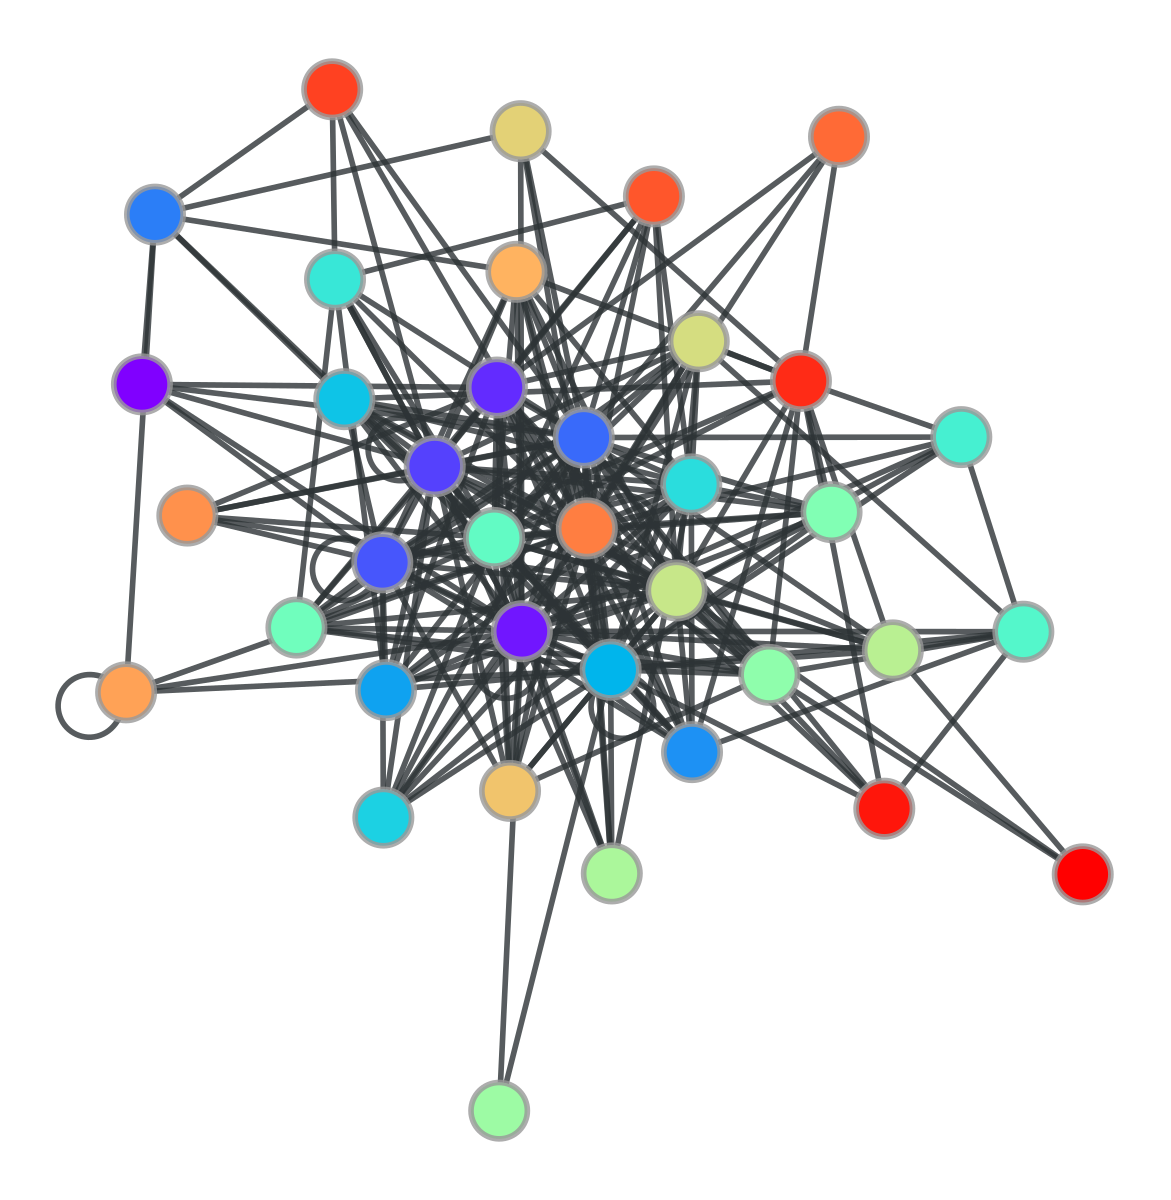

<Figure size 500x500 with 0 Axes>

In [116]:
# Draw network
obj = nd.NetAssembly(X_large,O_large,X_large.sum(axis=0,dtype=int))
obj.g = large_eco_network
obj.draw(with_networkx=False)

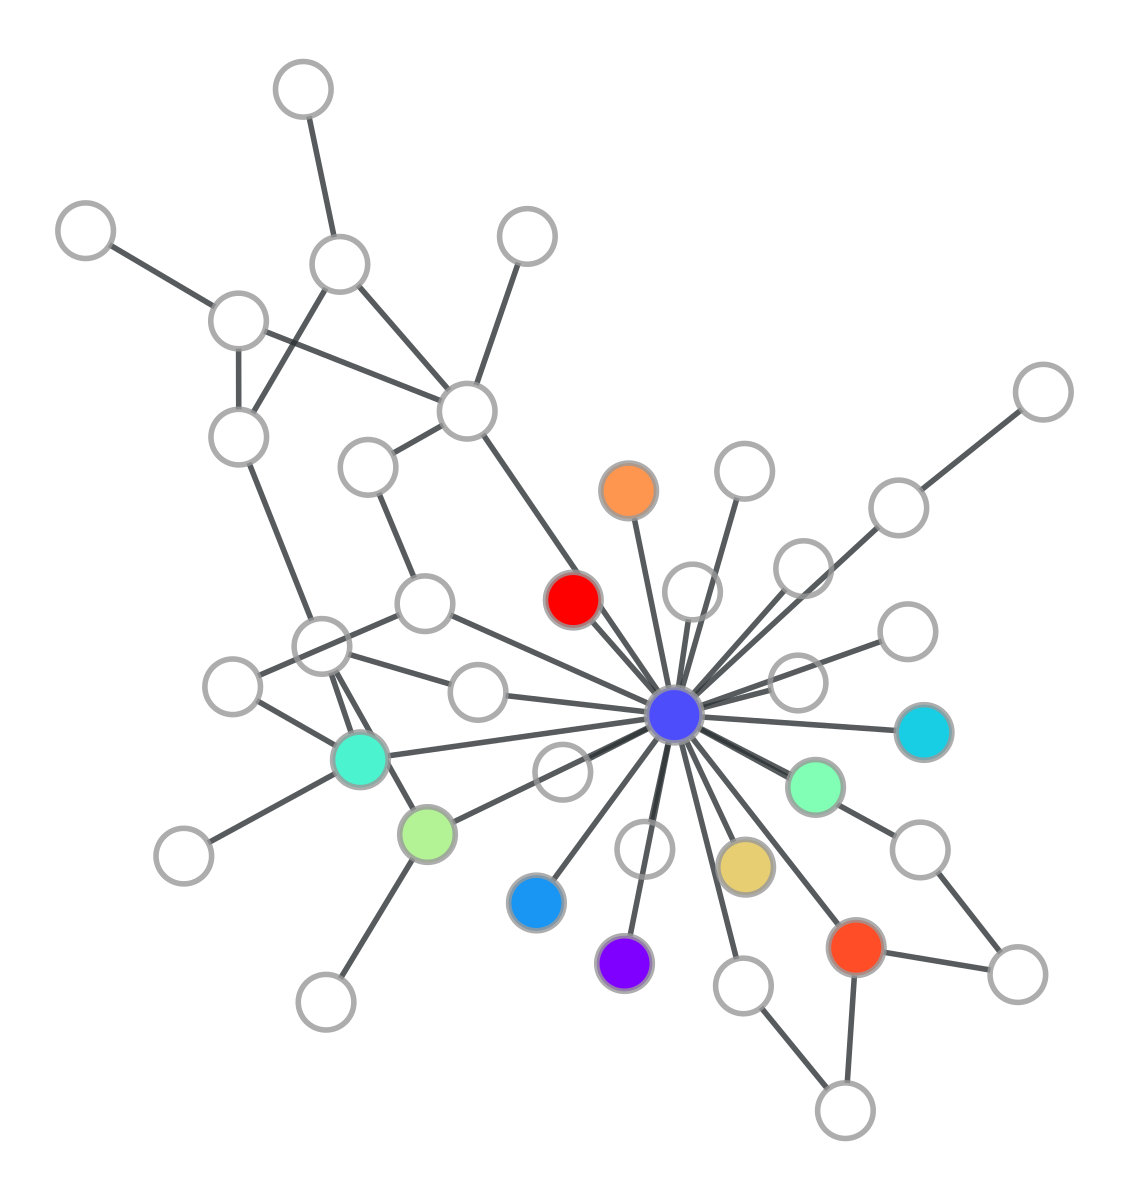

<Figure size 500x500 with 0 Axes>

In [121]:
# Draw network
obj = nd.NetAssembly(X_small,O_small,X_small.sum(axis=0,dtype=int))
obj.g = small_eco_network
obj.draw(with_networkx=False)

## Get network statistics

In [15]:
eco_large_N, eco_large_L, eco_large_avg_k, eco_large_div, eco_large_cycle = calc_stats(large_eco_network,X_large)

In [16]:
eco_small_N, eco_small_L, eco_small_avg_k, eco_small_div, eco_small_cycle = calc_stats(small_eco_network,X_small)

In [17]:
print_stats(large_eco_network,X_large,'Cyclic Ecological Network')

Cyclic Ecological Network
	N = 98
	k = 12.83673469387755
	d = 1.0
	|C| = 0.8457869634340223


In [18]:
print_stats(small_eco_network,X_small,'Acyclic Ecological Network')

Acyclic Ecological Network
	N = 94
	k = 2.4680851063829787
	d = 1.0
	|C| = 0.19827586206896552


## Analysis of Stabilization

In [21]:
# Read in assembled networks and measure accuracy
small_eco_analysis = data_path + 'analysis/EcoNets/A_PH_006_recon_2/'
large_eco_analysis = data_path + 'analysis/EcoNets/FW_013_05_recon_2/'

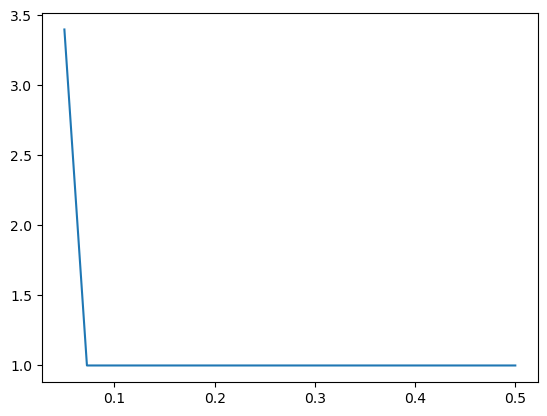

In [26]:
# Get number of components
large_num_comp = np.loadtxt(large_eco_analysis + 'num_comp.txt')
plt.plot(ratio_vals,large_num_comp.mean(axis=1))

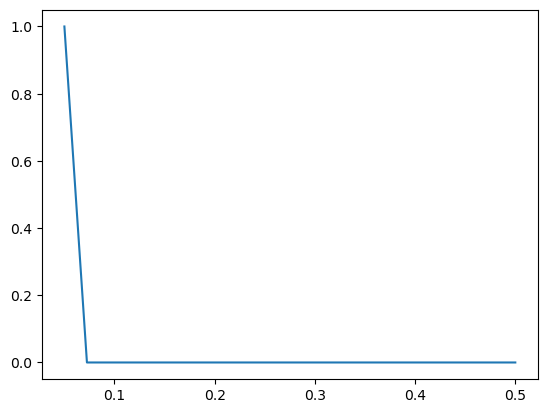

In [28]:
# Get number of components
large_num_iso_comp = np.loadtxt(large_eco_analysis + 'num_iso_comp.txt')
plt.plot(ratio_vals,large_num_iso_comp.mean(axis=1))

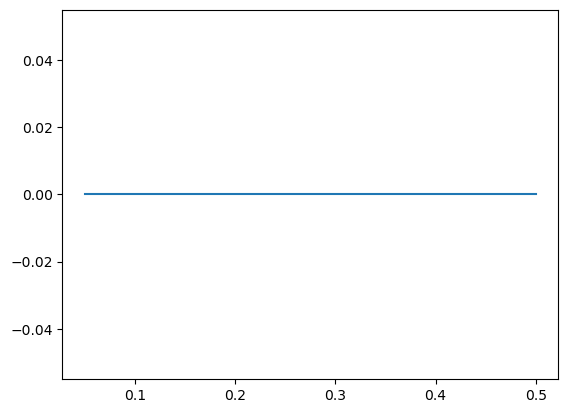

In [29]:
large_perf_iso_comp = np.loadtxt(large_eco_analysis + 'perf_iso.txt')
plt.plot(ratio_vals,large_perf_iso_comp.mean(axis=1))

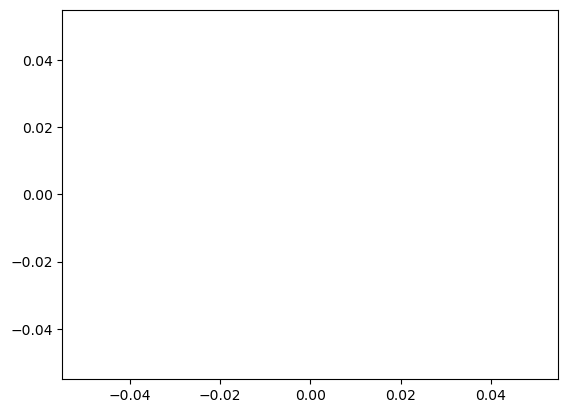

In [31]:
large_dist = np.load(large_eco_analysis + 'distance_metrics.npy')
plt.plot(ratio_vals,large_dist.mean(axis=1))

In [163]:
eco_small_path = '/work/ccnr/glover.co/net_design/NetDesign/data/EcoNets/M/'
detach_dirs = os.listdir(eco_small_path)
num_comp = np.zeros((len(detach_dirs),10))
num_iso_comp = np.zeros((len(detach_dirs),10))
for j,d in enumerate(detach_dirs):
    for i in range(10):
        g = nx.read_edgelist(eco_small_path+'/'+d+'/'+f'ex_{i}/g.txt')
        comp = list(nx.connected_components(g))
        num_comp[j,i] = len(comp)
        for c in comp:
            num_iso_comp[j,i] += nx.is_isomorphic(g,large_eco_network)
        

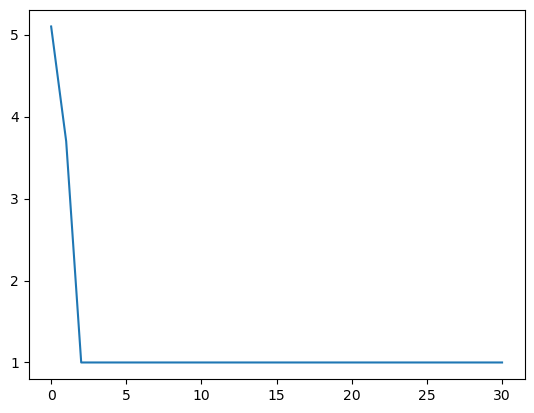

In [164]:
plt.plot(num_comp.mean(axis=1))

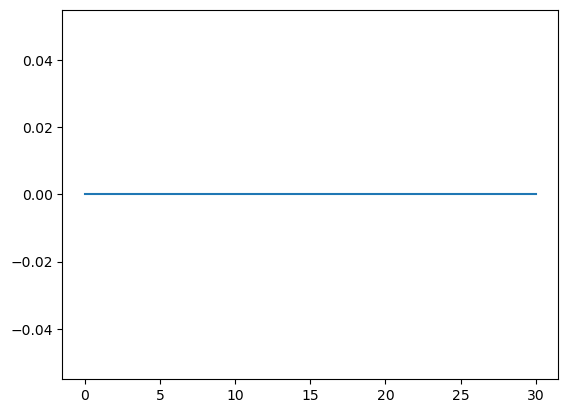

In [165]:
plt.plot(num_iso_comp.mean(axis=1))

# Lattice Networks

In [33]:
cubic_lattice = nx.read_edgelist(data_path+'lattice_data/cubic_graph.txt')

In [34]:
X = np.ones(100).reshape(100,1)

In [35]:
O = np.array([4]).reshape(1,1)

In [36]:
obj = nd.NetAssembly(X,O,X.sum(axis=0,dtype=int))

In [37]:
obj.g = cubic_lattice

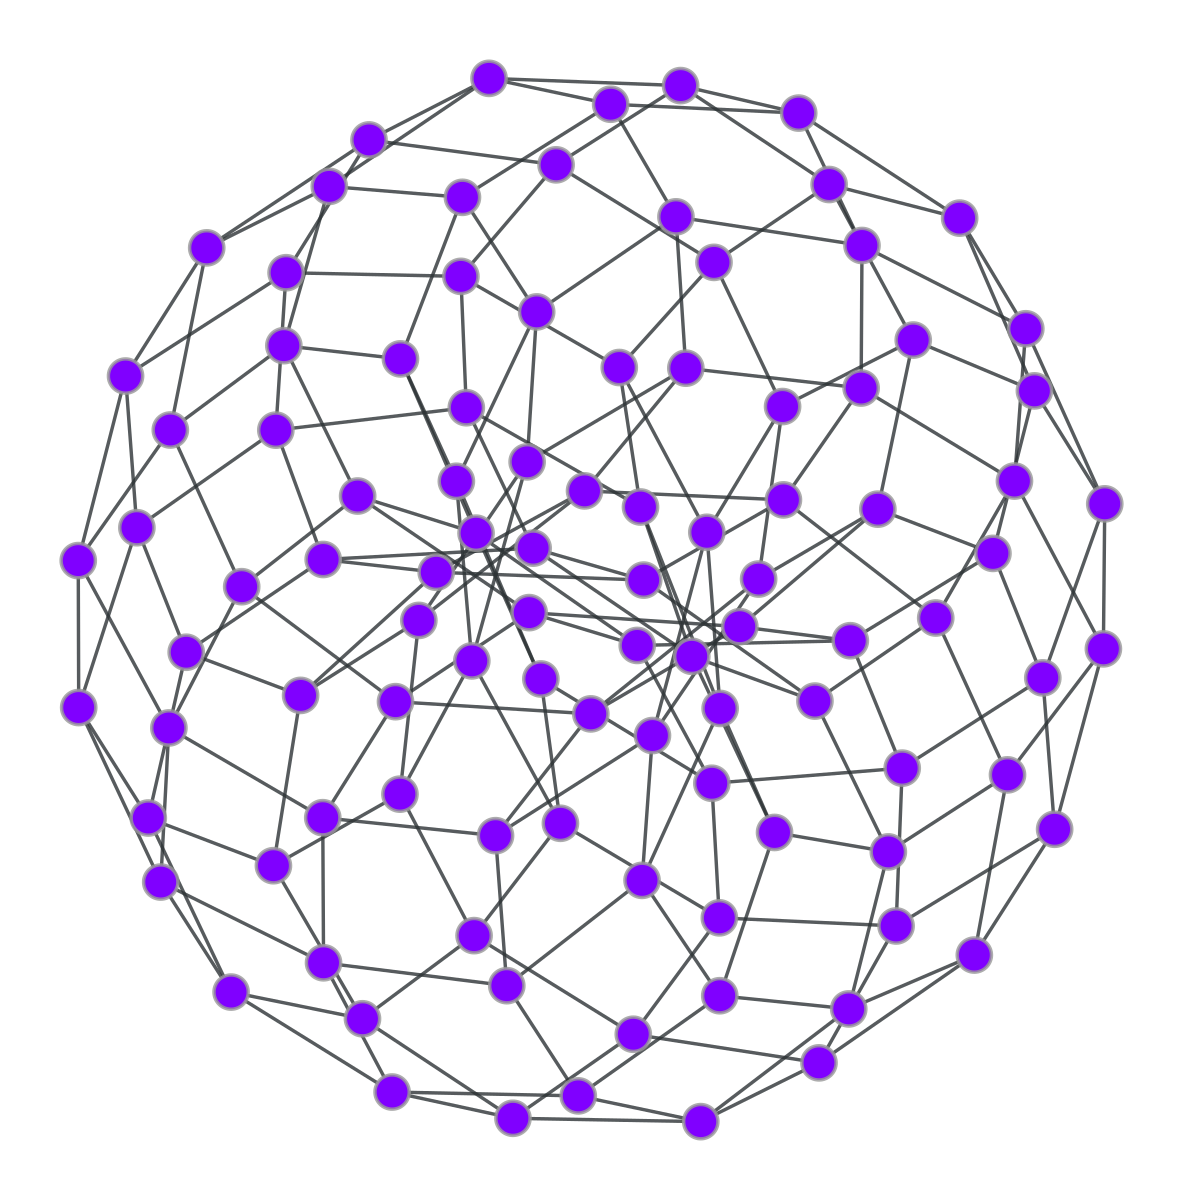

<Figure size 500x500 with 0 Axes>

In [38]:
obj.draw(with_networkx=False)

## Get network statistics

In [39]:
lattice_N, lattice_L, lattice_k, lattice_div, lattice_cyc = calc_stats(cubic_lattice,X)

In [40]:
print_stats(cubic_lattice,X,'Cubic Lattice')

Cubic Lattice
	N = 100
	k = 4.0
	d = 0.01
	|C| = 0.505


## Analysis of Stabilization

# Protein Networks

In [166]:
properties['proteins']['human']['CPX-6169']

{'N': 30,
 'kavg': 2.2,
 'cyclicity': 0.12121212121212122,
 'node_symmetry': 0.1,
 'graph_density': 0.07586206896551724,
 'node_heterogeneity': 0.13333333333333333,
 'degree_heterogeneity': 1.4696938456699071,
 'clustering': 0.03333333333333333,
 'Oness': 0.0}

In [10]:
# Get three proteins
# This has LOW O'NESS and HIGH DIV and LOW CYCLICITY
protein_high_div_low_cyc = nx.read_edgelist(data_path+'protein_complex/complex_portal/CPX-6036.edge',nodetype=int)
protein_high_div_low_cyc_X = np.loadtxt(data_path + 'protein_complex/complex_portal/X_CPX-6036.txt')
# Look for CPX-4402
protein_high_div_low_cyc_O = nd.extract_O(protein_high_div_low_cyc,protein_high_div_low_cyc_X)

In [11]:
# LOW O'NESS
protein_mid_div_mid_cyc = nx.read_edgelist(data_path+'protein_complex/complex_portal/CPX-2540.edge',nodetype=int)
protein_mid_div_mid_cyc_X = np.loadtxt(data_path + 'protein_complex/complex_portal/X_CPX-2540.txt')
protein_mid_div_mid_cyc_O = nd.extract_O(protein_mid_div_mid_cyc,protein_mid_div_mid_cyc_X)

In [12]:
# LOW ONESS
protein_low_div_high_cyc = nx.read_edgelist(data_path+'protein_complex/complex_portal/CPX-2234.edge',nodetype=int)
protein_low_div_high_cyc_X = np.loadtxt(data_path + 'protein_complex/complex_portal/X_CPX-2234.txt')
protein_low_div_high_cyc_O = nd.extract_O(protein_low_div_high_cyc,protein_low_div_high_cyc_X)

In [134]:
# LOW O'NESS
protein_low_div_low_cyc = nx.read_edgelist(data_path+'protein_complex/complex_portal/CPX-6169.edge',edgetype=int,nodetype=int)
# protein_low_div_low_cyc = nx.convert_node_labels_to_integers(protein_low_div_low_cyc)
protein_low_div_low_cyc_X = np.loadtxt(data_path + 'protein_complex/complex_portal/X_CPX-6169.txt')
protein_low_div_low_cyc_O = nd.extract_O(protein_low_div_low_cyc,protein_low_div_low_cyc_X)

In [89]:
protein_low_div_mid_O = nx.read_edgelist(data_path+'protein_complex/complex_portal/CPX-152.edge',nodetype=int)
protein_low_div_mid_O_X = np.loadtxt(data_path + 'protein_complex/complex_portal/X_CPX-152.txt')
protein_low_div_mid_O_O = nd.extract_O(protein_low_div_mid_O,protein_low_div_mid_O_X)
protein_low_div_high_O = nx.read_edgelist(data_path+'protein_complex/complex_portal/CPX-3905.edge',nodetype=int)
protein_low_div_high_O_X = np.loadtxt(data_path + 'protein_complex/complex_portal/X_CPX-3905.txt')
protein_low_div_high_O_O = nd.extract_O(protein_low_div_mid_O,protein_low_div_mid_O_X)

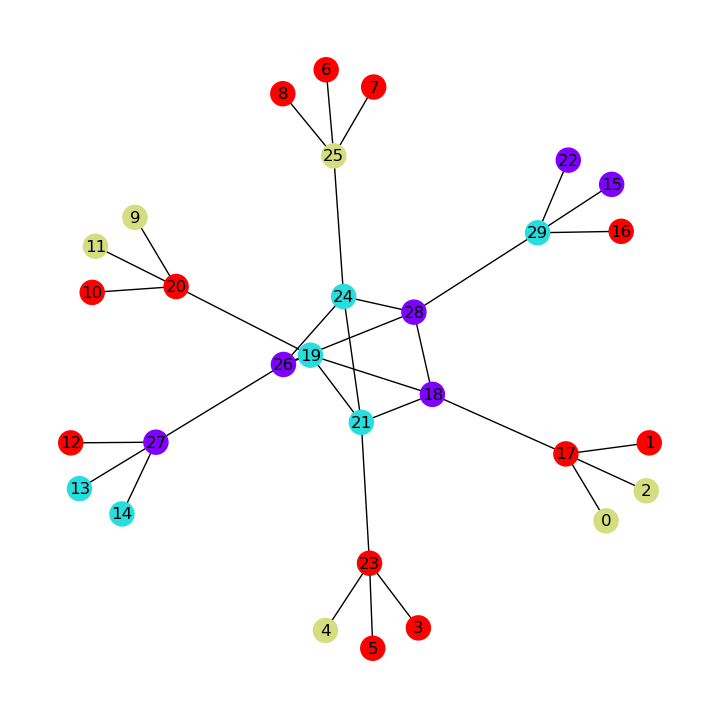

In [135]:
prot_high_low = nd.NetAssembly(protein_low_div_low_cyc_X,protein_low_div_low_cyc_O,protein_low_div_low_cyc_X.sum(axis=0,dtype=int))
prot_high_low.g = protein_low_div_low_cyc
prot_high_low.draw(with_networkx=True,figsize=(7,7),with_labels=True)

In [136]:
colors = {0:'r',2:'cyan',1:'r',17:'gold',
          4:'r',5:'cyan',3:'r',23:'gold',
          22:'r',16:'cyan',15:'r',29:'gold',
          6:'r',8:'cyan',7:'r',25:'gold',
          9:'r',11:'cyan',10:'r',20:'gold',
          14:'r',12:'cyan',13:'r',27:'gold',
          18:'springgreen',21:'springgreen',28:'springgreen',24:'springgreen',19:'springgreen',26:'springgreen'}

In [21]:
protein_low_div_low_cyc.edges()

EdgeView([(0, 17), (17, 1), (17, 2), (17, 18), (3, 23), (23, 4), (23, 5), (23, 21), (6, 25), (25, 7), (25, 8), (25, 24), (9, 20), (20, 10), (20, 11), (20, 19), (12, 27), (27, 13), (27, 14), (27, 26), (15, 29), (29, 16), (29, 22), (29, 28), (18, 19), (18, 28), (18, 21), (19, 21), (19, 26), (28, 24), (28, 26), (21, 24), (26, 24)])

In [137]:
node_order = list(protein_low_div_low_cyc.nodes())
node_order.index(17)

1

In [127]:
gt_prot = nd.nx2gt(recon_g)

In [128]:
color_key = plt.cm.rainbow(np.linspace(0, 1, protein_low_div_low_cyc_O.shape[0]))

In [143]:
vcolor = gt_prot.new_vp("vector<double>") 
list(gt_prot.vertices())
for i in range(protein_low_div_low_cyc.number_of_nodes()):
    vcolor[str(i)] = to_rgba(colors[node_order.index(i)])

In [144]:
O = nd.extract_O(protein_low_div_low_cyc,protein_low_div_low_cyc_X)

In [159]:
O

array([[0., 1., 1., 2.],
       [1., 3., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [145]:
protein_low_div_low_cyc_X

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

In [160]:
test = nd_cont.network(protein_low_div_low_cyc_X,O)
test.run(10000,link_attractiveness=1,link_resilience=0)

/work/ccnr/glover.co/net_design/NetDesign/network_design_cont_time.py:111: RuntimeWarning: divide by zero encountered in scalar divide
  self.event.append(np.sum(self.rates_detach)/np.sum(self.rates))


In [156]:
colors.keys()

dict_keys([0, 2, 1, 17, 4, 5, 3, 23, 22, 16, 15, 29, 6, 8, 7, 25, 9, 11, 10, 20, 14, 12, 13, 27, 18, 21, 28, 24, 19, 26])

In [157]:
test.g.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29))

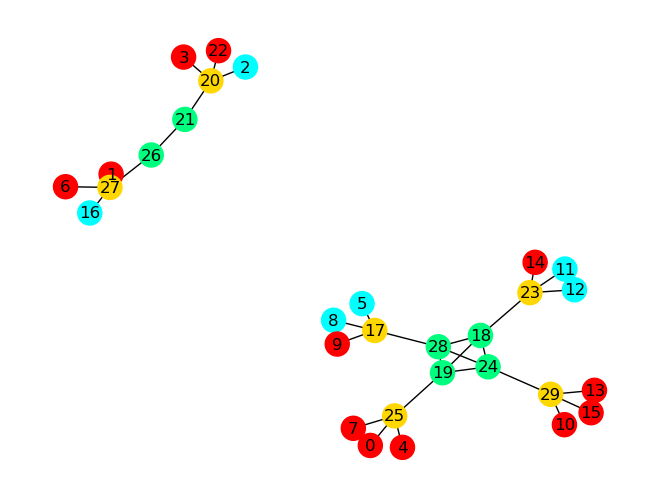

In [161]:
nx.draw(test.g,with_labels=True,node_color=[colors[i] for i in test.g.nodes()])

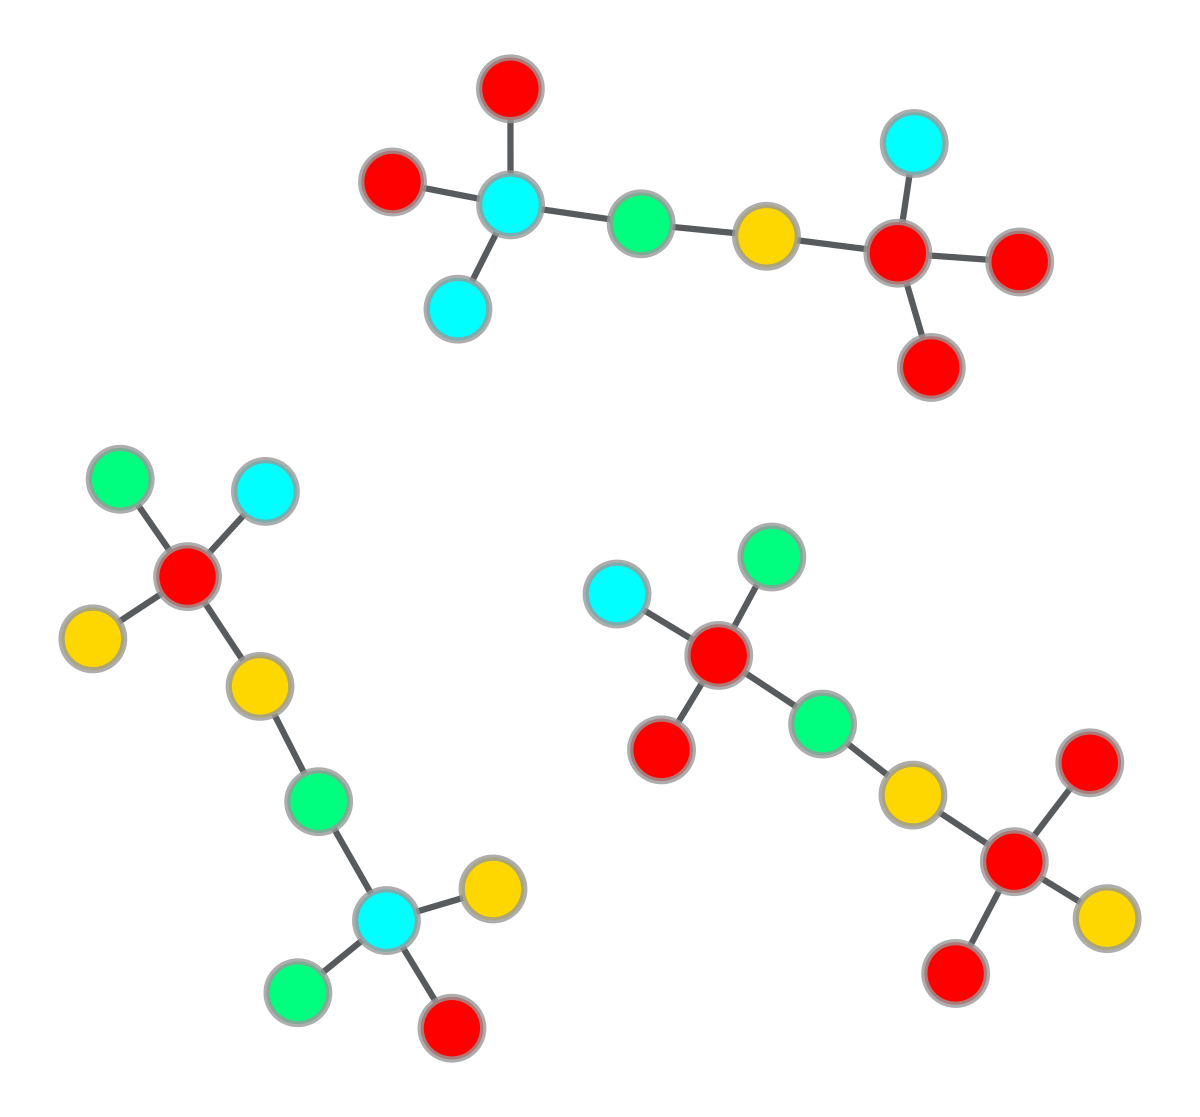

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x2ba1fd8fac30, at 0x2ba1fd6e4650>

In [141]:
gt.graph_draw(gt_prot,vertex_fill_color=vcolor)

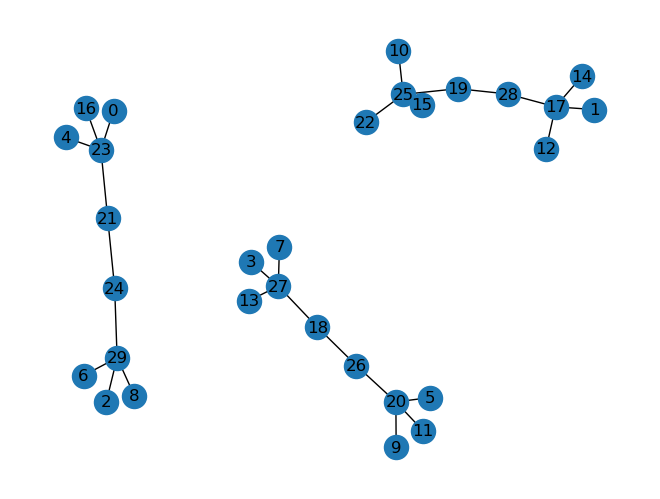

In [87]:
recon_g = nx.read_edgelist(data_path+'protein_complex/complex_portal/CPX-6169._recon_1/0.206/ex_0/g.txt')
nx.draw(recon_g,with_labels=True)

In [80]:
prot_mid = nd.NetAssembly(protein_mid_div_mid_cyc_X,protein_mid_div_mid_cyc_O,protein_mid_div_mid_cyc_X.sum(axis=0,dtype=int))
prot_mid.g = protein_mid_div_mid_cyc
prot_mid.draw(with_networkx=True,figsize=(2,2),with_labels=True,color_key=color_key)

IndexError: index 4 is out of bounds for axis 0 with size 4

<Figure size 200x200 with 0 Axes>

In [216]:
color_key = ['r','tab:blue','cyan','gold','springgreen']
node_colors = [to_rgba(color_key[np.argmax(protein_mid_div_mid_cyc_X[i])]) for i in range(protein_mid_div_mid_cyc_X.shape[0])]
protein_mid_div_mid_cyc_X, node_colors

(array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 [(1.0, 0.0, 0.0, 1),
  (1.0, 0.0, 0.0, 1),
  (0.0, 1.0, 0.4980392156862745, 1.0),
  (1.0, 0.8431372549019608, 0.0, 1.0),
  (1.0, 0.8431372549019608, 0.0, 1.0),
  (0.0, 1.0, 1.0, 1.0),
  (0.0, 1.0, 1.0, 1.0),
  (0.0, 1.0, 1.0, 1.0),
  (0.0, 1.0, 1.0, 1.0),
  (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)])

In [186]:
color_key

['r', 'tab:blue', 'cyan', 'gold', 'springgreen']

In [315]:
protein_mid_div_mid_cyc_X

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [175]:
X

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

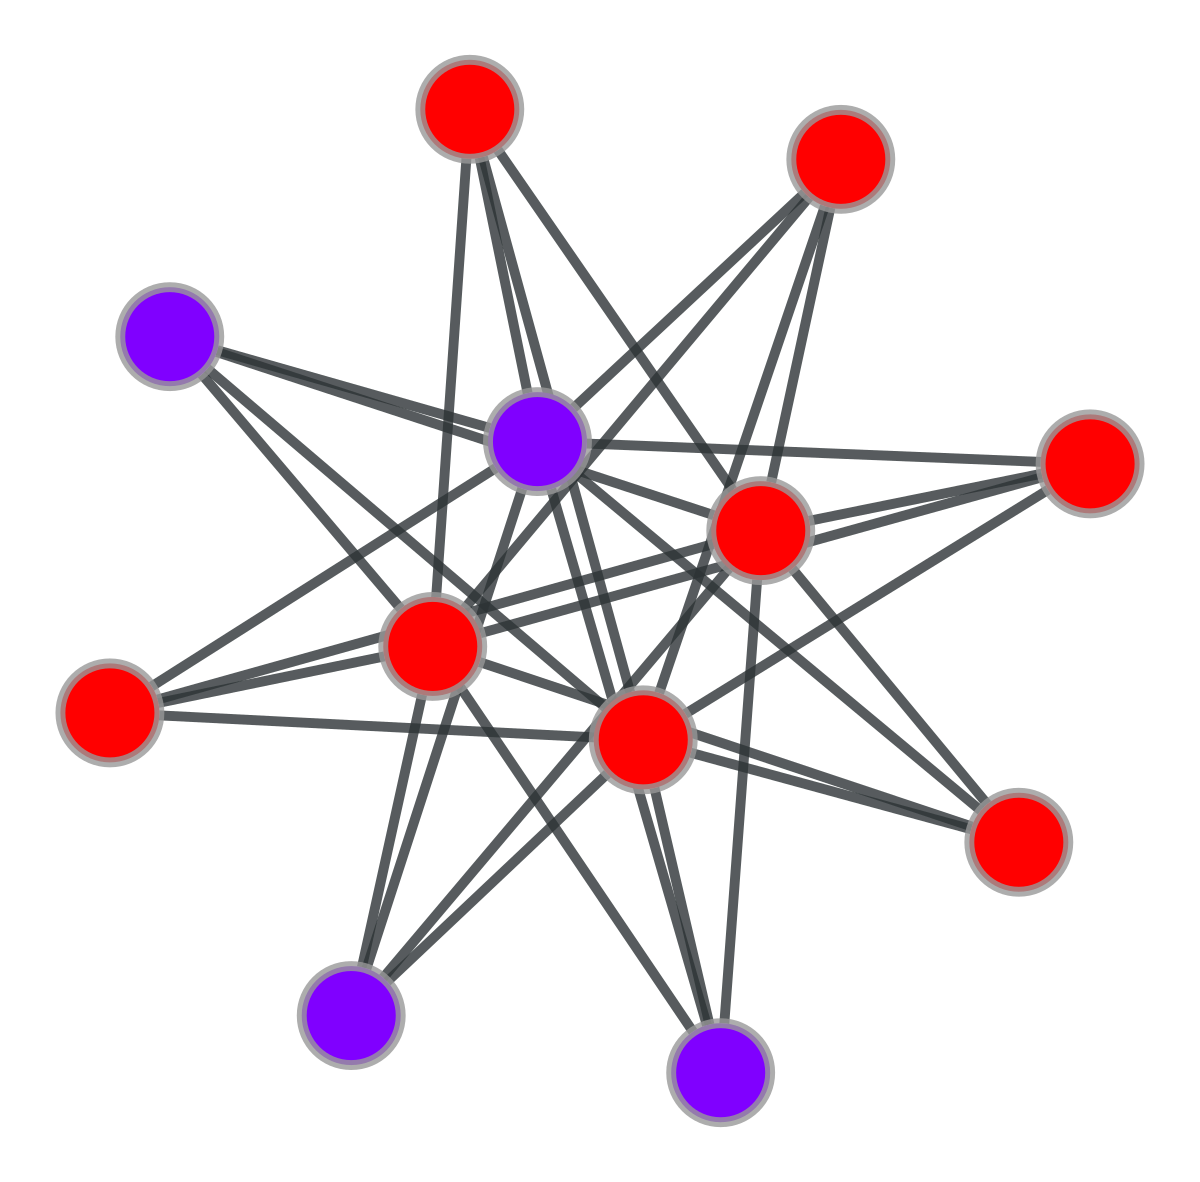

<Figure size 200x200 with 0 Axes>

In [174]:
prot_low_high = nd.NetAssembly(protein_low_div_high_cyc_X,protein_low_div_high_cyc_O,protein_low_div_high_cyc_X.sum(axis=0,dtype=int))
prot_low_high.g = protein_low_div_high_cyc
prot_low_high.draw(with_networkx=False,figsize=(2,2))

In [318]:
protein_low_div_high_cyc_O

array([[0., 8.],
       [4., 0.]])

## Get network statistics

In [319]:
protein_high_div_low_cyc_N, protein_high_div_low_cyc_L, protein_high_div_low_cyc_k, protein_high_div_low_cyc_div, protein_high_div_low_cyc_cyc = calc_stats(protein_high_div_low_cyc,protein_high_div_low_cyc_X)
print_stats(protein_high_div_low_cyc,protein_high_div_low_cyc_X,'Protein High Diversity, Low Cyclity:')

Protein High Diversity, Low Cyclity:
	N = 13
	k = 2.0
	d = 1.0
	|C| = 0.07692307692307693


In [320]:
protein_low_div_high_cyc_N, protein_low_div_high_cyc_L, protein_low_div_high_cyc_k, protein_low_div_high_cyc_div, protein_low_div_high_cyc_cyc = calc_stats(protein_low_div_high_cyc,protein_low_div_high_cyc_X)
print_stats(protein_low_div_high_cyc,protein_low_div_high_cyc_X,'Protein Low Diversity, High Cyclity:')

Protein Low Diversity, High Cyclity:
	N = 12
	k = 5.333333333333333
	d = 0.16666666666666666
	|C| = 0.65625


In [321]:
protein_mid_div_mid_cyc_N, protein_mid_div_mid_cyc_L, protein_mid_div_mid_cyc_k, protein_mid_div_mid_cyc_div, protein_mid_div_mid_cyc_cyc = calc_stats(protein_mid_div_mid_cyc,protein_mid_div_mid_cyc_X)
print_stats(protein_mid_div_mid_cyc,protein_mid_div_mid_cyc_X,'Protein Mid Diversity, Mid Cyclity:')

Protein Mid Diversity, Mid Cyclity:
	N = 10
	k = 3.2
	d = 0.5
	|C| = 0.4375


## Analysis

### Protein High Div. Low Cyc.

In [122]:
protein_high_div_low_cyc_analysis_path = data_path + 'analysis/protein_complex/CPX-6036._recon_2/'

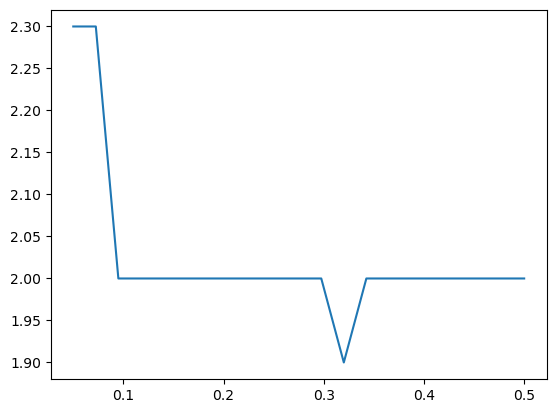

In [124]:
protein_high_div_low_cyc_num_comp = np.loadtxt(protein_high_div_low_cyc_analysis_path + 'num_comp.txt')
plt.plot(ratio_vals,protein_high_div_low_cyc_num_comp.mean(axis=1))

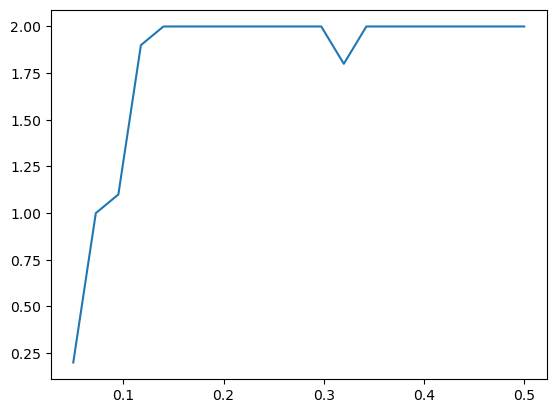

In [125]:
protein_high_div_low_cyc_num_iso_comp = np.loadtxt(protein_high_div_low_cyc_analysis_path + 'num_iso_comp.txt')
plt.plot(ratio_vals,protein_high_div_low_cyc_num_iso_comp.mean(axis=1))

### Protein Mid Div. Mid Cyc.

In [130]:
protein_mid_div_mid_cyc_analysis_path = data_path + 'analysis/protein_complex/CPX-2540._recon_2/'

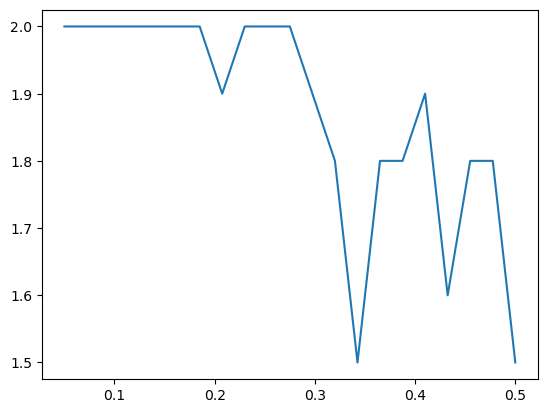

In [131]:
protein_mid_div_mid_cyc_num_comp = np.loadtxt(protein_mid_div_mid_cyc_analysis_path + 'num_comp.txt')
plt.plot(ratio_vals,protein_mid_div_mid_cyc_num_comp.mean(axis=1))

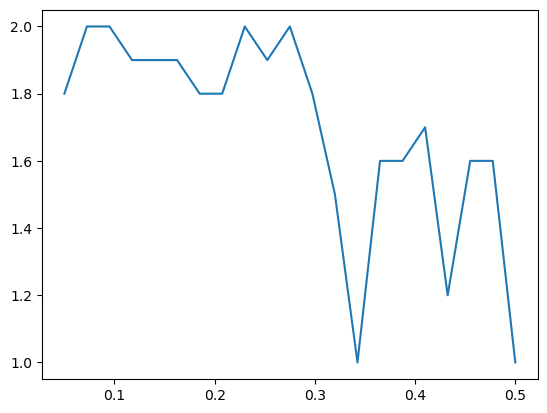

In [132]:
protein_mid_div_mid_cyc_num_iso_comp = np.loadtxt(protein_mid_div_mid_cyc_analysis_path + 'num_iso_comp.txt')
plt.plot(ratio_vals,protein_mid_div_mid_cyc_num_iso_comp.mean(axis=1))

### Protein Low Div. Low Cyc.

In [68]:
protein_low_div_low_cyc_analysis_path = data_path + 'analysis/protein_complex/CPX-6169._recon_1/'

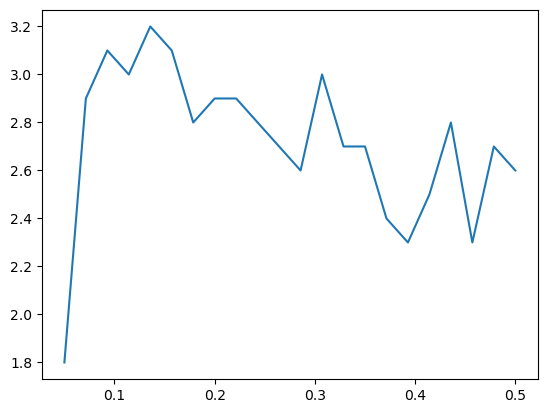

In [69]:
protein_low_div_low_cyc_num_comp = np.loadtxt(protein_low_div_low_cyc_analysis_path + 'num_comp.txt')
plt.plot(ratio_vals,protein_low_div_low_cyc_num_comp.mean(axis=1))

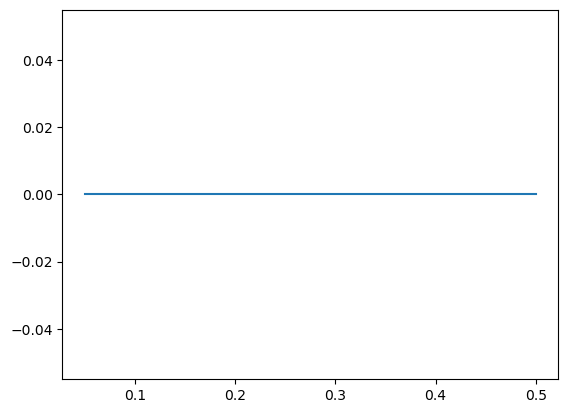

In [70]:
protein_low_div_low_cyc_num_iso_comp = np.loadtxt(protein_low_div_low_cyc_analysis_path + 'num_iso_comp.txt')
plt.plot(ratio_vals,protein_low_div_low_cyc_num_iso_comp.mean(axis=1))

### Protein Low Div. Low O

In [136]:
protein_low_div_low_O_analysis_path = data_path + 'analysis/protein_complex/CPX-152._recon_2/'

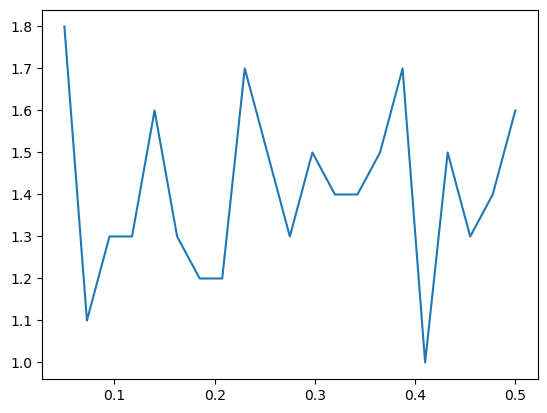

In [137]:
protein_low_div_low_O_num_comp = np.loadtxt(protein_low_div_low_O_analysis_path + 'num_comp.txt')
plt.plot(ratio_vals,protein_low_div_low_O_num_comp.mean(axis=1))

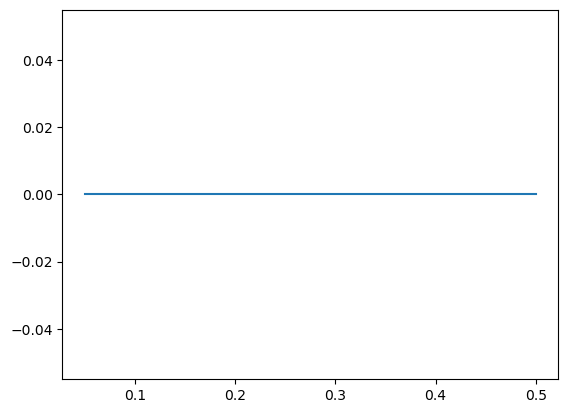

In [138]:
protein_low_div_low_O_num_iso_comp = np.loadtxt(protein_low_div_low_O_analysis_path + 'num_iso_comp.txt')
plt.plot(ratio_vals,protein_low_div_low_O_num_iso_comp.mean(axis=1))

### Protein Low Div. High O.

In [141]:
protein_low_div_high_O_analysis_path = data_path + 'analysis/protein_complex/CPX-3905._recon_2/'

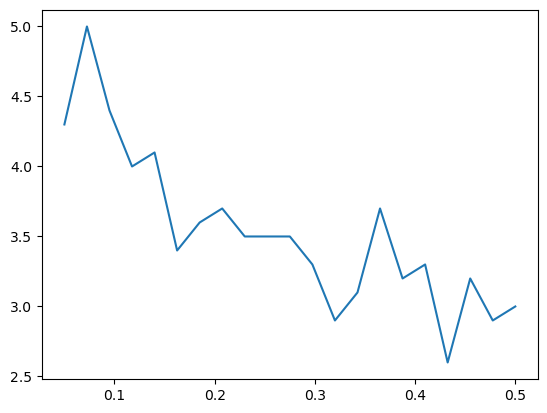

In [142]:
protein_low_div_high_O_num_comp = np.loadtxt(protein_low_div_high_O_analysis_path + 'num_comp.txt')
plt.plot(ratio_vals,protein_low_div_high_O_num_comp.mean(axis=1))

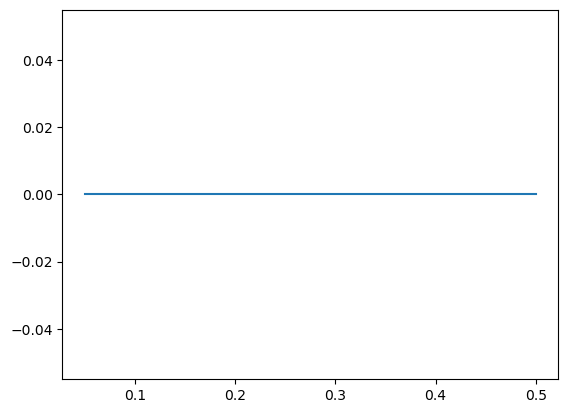

In [143]:
protein_low_div_high_O_num_iso_comp = np.loadtxt(protein_low_div_high_O_analysis_path + 'num_iso_comp.txt')
plt.plot(ratio_vals,protein_low_div_high_O_num_iso_comp.mean(axis=1))

### Protein Low Div. high Cyc. 

In [148]:
protein_low_div_high_cyc_analysis_path = data_path + 'analysis/protein_complex/CPX-2234._recon_2/'

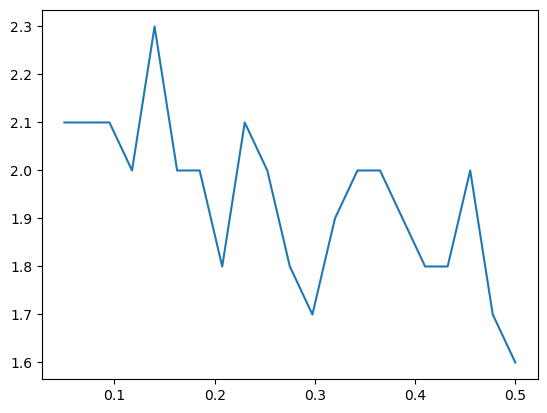

In [149]:
protein_low_div_high_cyc_num_comp = np.loadtxt(protein_low_div_high_cyc_analysis_path + 'num_comp.txt')
plt.plot(ratio_vals,protein_low_div_high_cyc_num_comp.mean(axis=1))

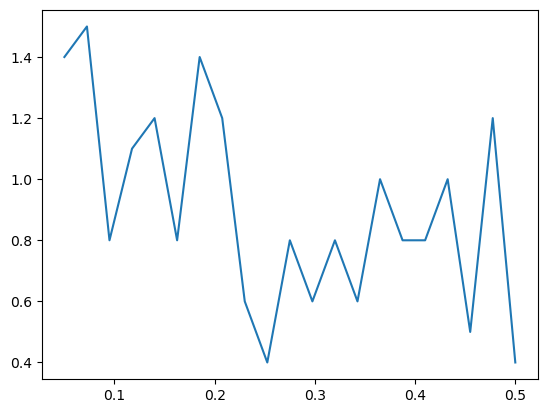

In [150]:
protein_low_div_high_cyc_num_iso_comp = np.loadtxt(protein_low_div_high_cyc_analysis_path + 'num_iso_comp.txt')
plt.plot(ratio_vals,protein_low_div_high_cyc_num_iso_comp.mean(axis=1))

# Molecule Networks

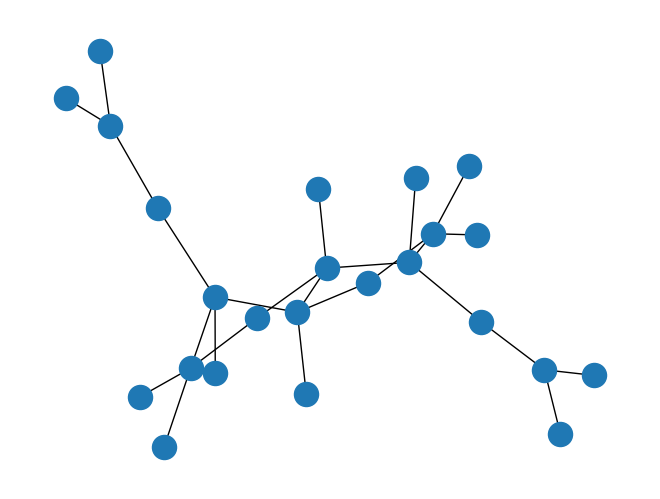

In [41]:
molecule = nx.read_edgelist(data_path + 'Molecules/CID_6883.txt')
nx.draw(molecule)

## Accuracy

In [42]:
molecule_analysis_path = data_path + 'analysis/Molecules/CID_6883_recon_2/'

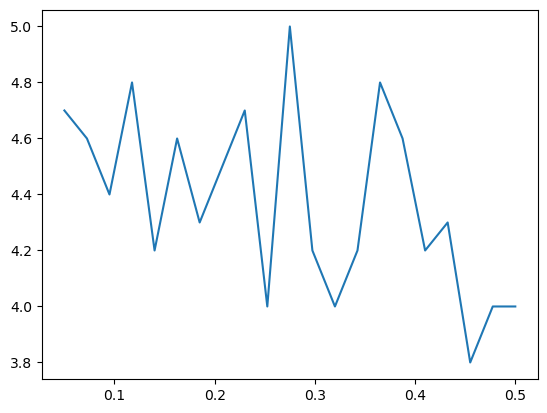

In [44]:
molecule_num_comp = np.loadtxt(molecule_analysis_path + 'num_comp.txt')
plt.plot(ratio_vals,molecule_num_comp.mean(axis=1))

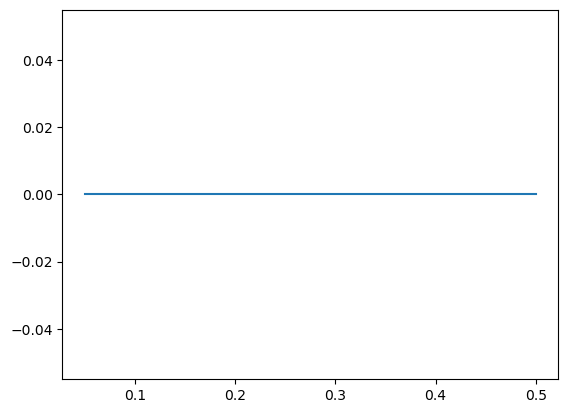

In [45]:
molecule_num_iso_comp = np.loadtxt(molecule_analysis_path + 'num_iso_comp.txt')
plt.plot(ratio_vals,molecule_num_iso_comp.mean(axis=1))

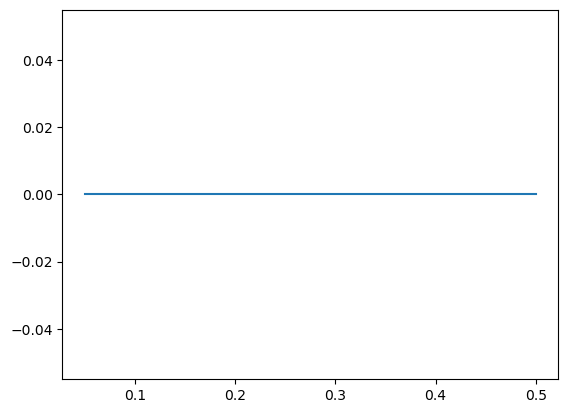

In [46]:
molecule_perf_iso = np.loadtxt(molecule_analysis_path + 'perf_iso.txt')
plt.plot(ratio_vals,molecule_perf_iso.mean(axis=1))

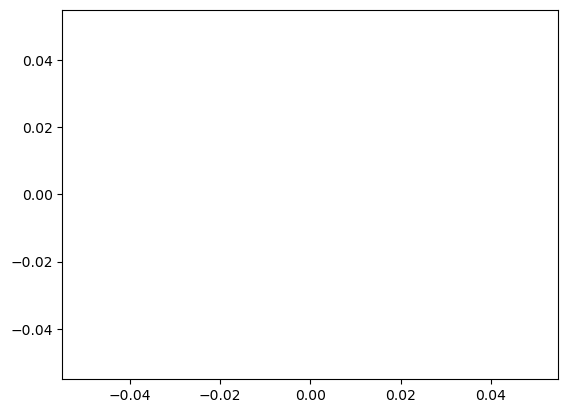

In [47]:
molecule_dist = np.load(molecule_analysis_path + 'distance_metrics_size_controlled.npy')
plt.plot(ratio_vals,molecule_dist.mean(axis=1))

# Lego Networks

In [386]:
high_cyclicity_networks = {}
for category, subdirs in properties.items():
    for subdir, networks in subdirs.items():
        for network_name, data in networks.items():
            if data.get('node_heterogeneity', 0) >.4 and data.get('Oness',0) > .5:
                high_cyclicity_networks[network_name] = {
                    'category': category,
                    'subdir': subdir,
                    'diversity': data['node_heterogeneity']
                }

In [387]:
high_cyclicity_networks

{'lpub3d_000010': {'category': 'lego',
  'subdir': 'architecture',
  'diversity': 0.5},
 'CPX-10333': {'category': 'proteins', 'subdir': 'human', 'diversity': 0.5},
 'CPX-2159': {'category': 'proteins', 'subdir': 'human', 'diversity': 0.6},
 'CPX-2167': {'category': 'proteins', 'subdir': 'human', 'diversity': 0.6},
 'CPX-2954': {'category': 'proteins', 'subdir': 'human', 'diversity': 0.6},
 'CPX-8302': {'category': 'proteins', 'subdir': 'human', 'diversity': 0.5},
 'CPX-8918': {'category': 'proteins', 'subdir': 'human', 'diversity': 0.5},
 'CPX-8947': {'category': 'proteins', 'subdir': 'human', 'diversity': 0.6},
 'CPX-9001': {'category': 'proteins',
  'subdir': 'human',
  'diversity': 0.42857142857142855},
 'CID_3657': {'category': 'molecules',
  'subdir': 'WHO',
  'diversity': 0.4444444444444444}}

In [48]:
lego_low_div_low_cyc = 'classics/lpub3d_000007'
lego_mid_div_low_cyc = 'classics/lpub3d_000008'
lego_low_div_mid_cyc = 'architecture/lpub3d_000004'
lego_low_div_high_O = 'synthetic/test_lpub3d_000009'
lego_high_div_high_O = 'architecture/lpub3d_000010'

### Lego Low Div. Mid Cyc.

In [57]:
lego_low_div_mid_cyc_analysis_path = data_path + 'analysis/lego/g_architecture_lpub3d_000004_recon_2/'

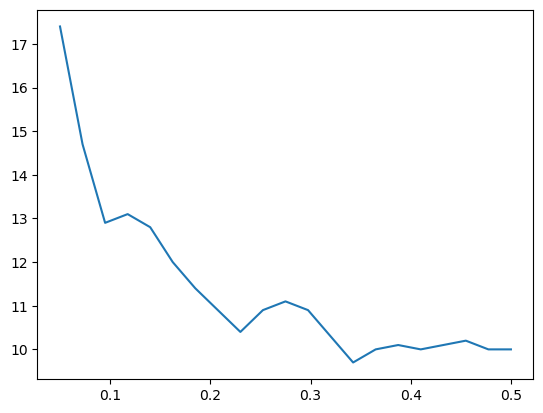

In [58]:
lego_low_div_mid_cyc_num_comp = np.loadtxt(lego_low_div_mid_cyc_analysis_path + 'num_comp.txt')
plt.plot(ratio_vals,lego_low_div_mid_cyc_num_comp.mean(axis=1))

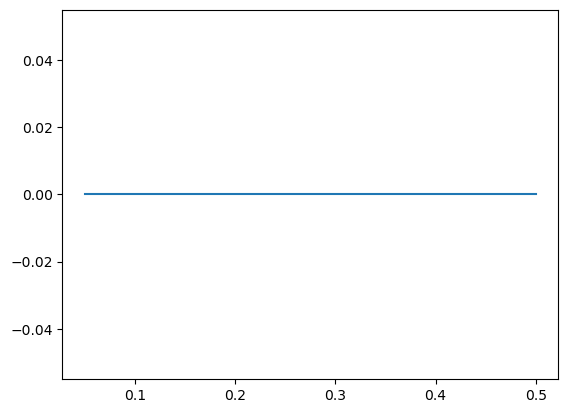

In [60]:
lego_low_div_mid_cyc_iso_comp = np.loadtxt(lego_low_div_mid_cyc_analysis_path + 'num_iso_comp.txt')
plt.plot(ratio_vals,lego_low_div_mid_cyc_iso_comp.mean(axis=1))

### Lego Low Div. Low Cyc.

In [62]:
lego_low_div_low_cyc_analysis_path = data_path + 'analysis/lego/g_classics_lpub3d_000008_recon_2/'

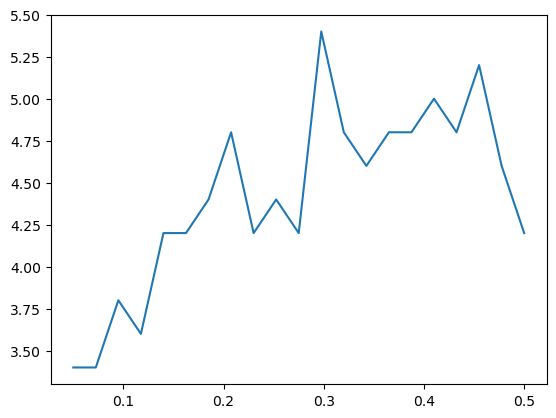

In [64]:
lego_low_div_low_cyc_num_comp = np.loadtxt(lego_low_div_low_cyc_analysis_path + 'num_comp.txt')
plt.plot(ratio_vals,lego_low_div_low_cyc_num_comp.mean(axis=1))

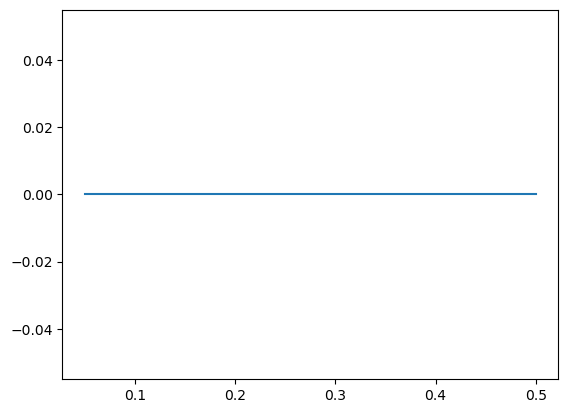

In [65]:
lego_low_div_low_cyc_num_iso_comp = np.loadtxt(lego_low_div_low_cyc_analysis_path + 'num_iso_comp.txt')
plt.plot(ratio_vals,lego_low_div_low_cyc_num_iso_comp.mean(axis=1))

### Lego Mid Div. Low Cyc.

In [66]:
lego_mid_div_low_cyc_analysis_path = data_path + 'analysis/lego/g_classics_lpub3d_000008_recon_2/'

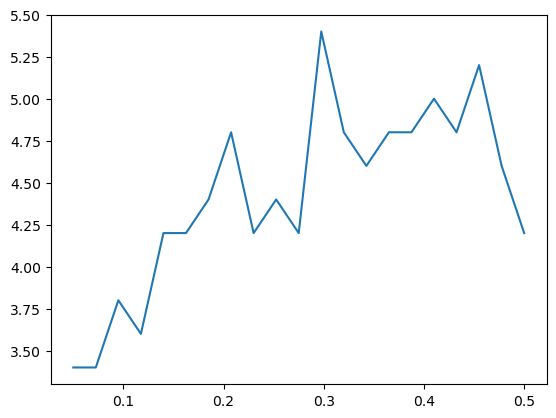

In [67]:
lego_mid_div_low_cyc_num_comp = np.loadtxt(lego_mid_div_low_cyc_analysis_path + 'num_comp.txt')
plt.plot(ratio_vals,lego_mid_div_low_cyc_num_comp.mean(axis=1))

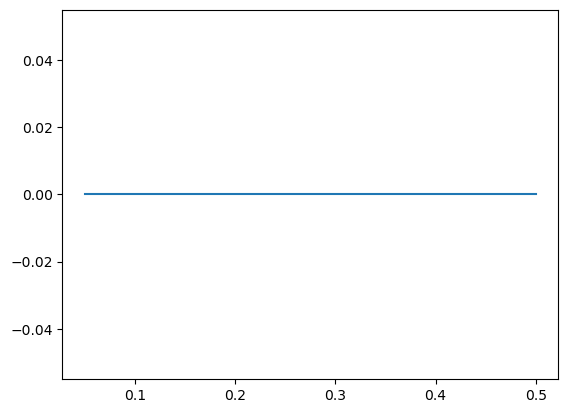

In [68]:
lego_mid_div_low_cyc_num_iso_comp = np.loadtxt(lego_mid_div_low_cyc_analysis_path + 'num_iso_comp.txt')
plt.plot(ratio_vals,lego_mid_div_low_cyc_num_iso_comp.mean(axis=1))

### Lego High Div. High O.

In [69]:
lego_high_div_high_O_analysis_path = data_path + 'analysis/lego/g_architecture_lpub3d_000010_recon_2/'

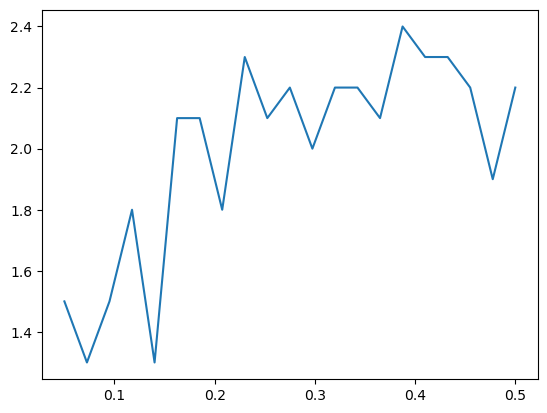

In [70]:
lego_high_div_high_O_num_comp = np.loadtxt(lego_high_div_high_O_analysis_path + 'num_comp.txt')
plt.plot(ratio_vals,lego_high_div_high_O_num_comp.mean(axis=1))

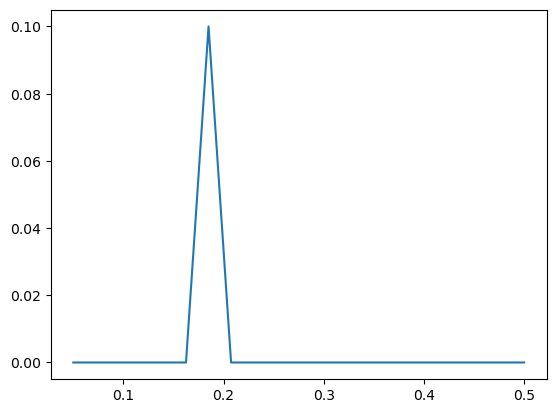

In [71]:
lego_high_div_high_O_num_iso_comp = np.loadtxt(lego_high_div_high_O_analysis_path + 'num_iso_comp.txt')
plt.plot(ratio_vals,lego_high_div_high_O_num_iso_comp.mean(axis=1))

In [35]:
lego_g = nx.read_edgelist(data_path + 'lego/networks/g_architecture_lpub3d_000010.txt',nodetype=int)
lego_X = np.loadtxt(data_path + 'lego/networks/X_architecture_lpub3d_000010.txt')

In [36]:
lego_X

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [42]:
color_key = ['r','r','r','gold','tab:blue','gold']

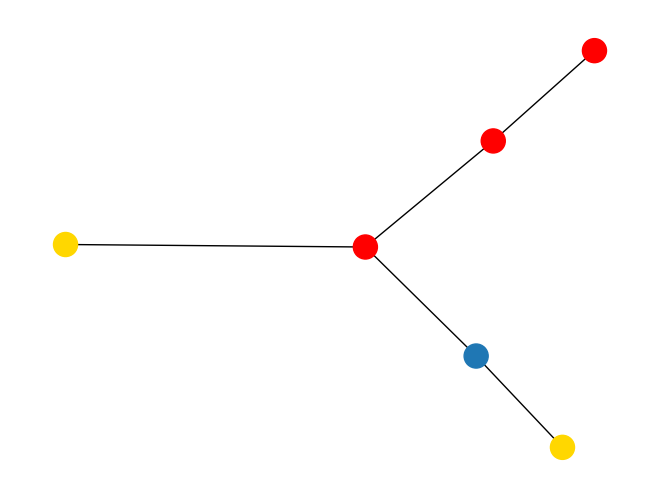

In [43]:
nx.draw(lego_g,node_color=color_key)